# comparison of parameters


Gespeichert:
C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Vergleich_andere_Parameter/Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite.png
C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Vergleich_andere_Parameter/Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite.pdf
Hinweis: panel_height_cm = 7 cm; n_breaks = 5



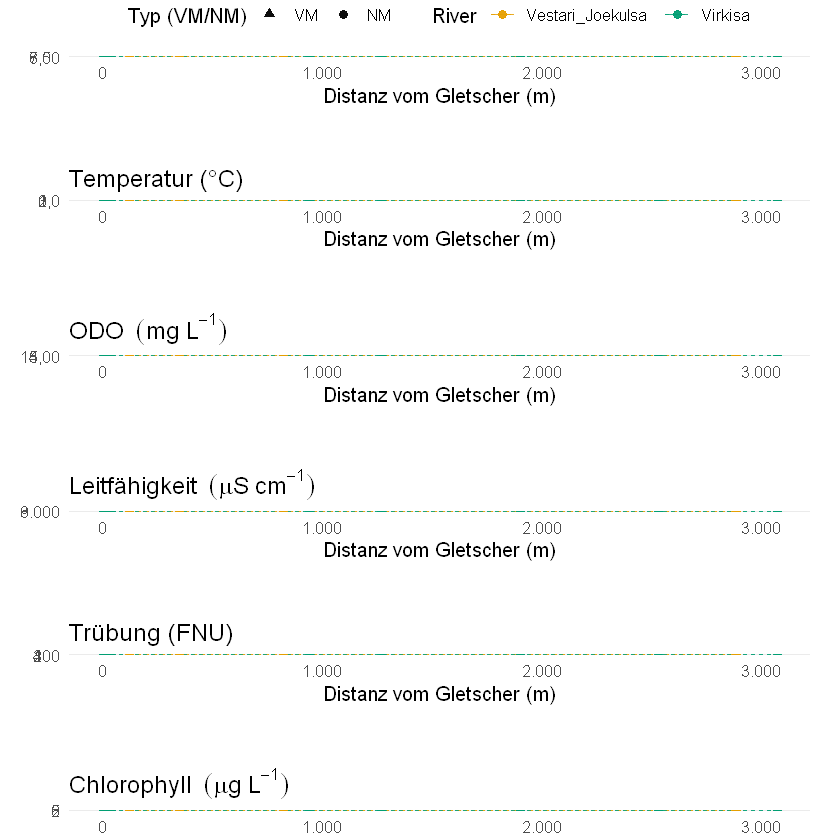

In [36]:
# ---- Setup ----
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2)
  library(scales); library(patchwork)
})

# Pfade
win_base <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
in_xls   <- file.path(win_base, "Sophia_Data.xls")
out_dir  <- file.path(win_base, "Vergleich_andere_Parameter")
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)
if (!file.exists(in_xls) && file.exists("/mnt/data/Sophia_Data.xls")) in_xls <- "/mnt/data/Sophia_Data.xls"

# ---- Daten laden ----
dat <- read_excel(in_xls)
names(dat) <- gsub("\\s+", "_", names(dat))

river_col <- "river_name"
dist_col  <- "distance_from_glacier"

params <- c("pH","Temp_C","ODO_mgperL","Cond_uSpercm","Turbidity_FNU","Chlorophyll_ugperL")
params <- params[params %in% names(dat)]
stopifnot(length(params) > 0)

# VM/NM identifizieren
vmnm_col <- NULL
for (cn in names(dat)) {
  vals <- unique(toupper(as.character(dat[[cn]])))
  if (any(vals %in% c("VM","NM"))) { vmnm_col <- cn; break }
}
stopifnot(!is.null(vmnm_col))

# optionale Gruppen-Spalte (für Virkisá Group 1)
group_candidates <- c("group_nr","Group","group","grp")
group_col <- group_candidates[group_candidates %in% names(dat)][1]

# Numerik (Komma→Punkt)
to_num <- function(x) suppressWarnings(as.numeric(gsub(",", ".", as.character(x))))
dat <- dat %>%
  mutate(Distance_m = to_num(.data[[dist_col]])) %>%
  mutate(across(all_of(params), to_num))

# Filter: ≤ 3100 m & Virkisá nur Group 1 (falls vorhanden)
df <- dat %>%
  mutate(River = as.character(.data[[river_col]]),
         VMNM  = toupper(as.character(.data[[vmnm_col]]))) %>%
  filter(!is.na(Distance_m), Distance_m <= 3100)

if (!is.na(group_col) && !is.null(group_col)) {
  df <- df %>%
    mutate(.grp = suppressWarnings(as.numeric(.data[[group_col]]))) %>%
    filter(River != "Virkisa" | .grp == 1)
}

# Long
df_long <- df %>%
  select(River, Distance_m, VMNM, all_of(params)) %>%
  pivot_longer(cols = all_of(params), names_to = "Parameter", values_to = "Value") %>%
  mutate(
    River = factor(River, levels = c("Vestari_Joekulsa","Virkisa")),
    VMNM  = factor(VMNM, levels = c("VM","NM"))
  )

# Labels
param_titles <- c(
  pH = "pH (–)",
  Temp_C = "Temperatur (°C)",
  ODO_mgperL = expression(ODO~~(mg~L^{-1})),
  Cond_uSpercm = expression(Leitfähigkeit~~(mu*S~cm^{-1})),
  Turbidity_FNU = "Trübung (FNU)",
  Chlorophyll_ugperL = expression(Chlorophyll~~(mu*g~L^{-1}))
)

# ======= HIER Farben ändern =======
col_vestari <- "#E69F00"   # z.B. "#D55E00"
col_virkisa <- "#009E73"   # z.B. "#0072B2"
cols <- c("Vestari_Joekulsa" = col_vestari,
          "Virkisa"          = col_virkisa)
# ==================================
shps <- c("VM" = 17, "NM" = 16)  # ▲ / ●

# -------- Helfer: dynamische Limits & Label-Genauigkeit --------
n_breaks <- 5           # <- Anzahl Tick-Intervalle (weniger = mehr Platz zwischen Ticks)
pad_frac <- 0.10        # <- Puffer um min/max
panel_limits_and_labels <- function(y, param, n_breaks = 5, pad_frac = 0.08) {
  r <- range(y, na.rm = TRUE)
  if (!all(is.finite(r))) r <- c(0, 1)
  if (diff(r) == 0) r <- r + c(-0.5, 0.5)
  pad <- pad_frac * diff(r)
  lower <- r[1] - pad
  upper <- r[2] + pad
  step_est <- (upper - lower) / n_breaks
  accuracy <- if (param %in% c("pH","ODO_mgperL")) 0.01 else if (step_est >= 1) 1 else if (step_est >= 0.5) 0.1 else if (step_est >= 0.2) 0.05 else 0.01
  list(
    limits = c(lower, upper),
    breaks = breaks_extended(n_breaks),
    labels = label_number(accuracy = accuracy, decimal.mark = ",", big.mark = ".")
  )
}

# Panel-Builder
make_panel <- function(param) {
  d <- dplyr::filter(df_long, Parameter == param)
  cfg <- panel_limits_and_labels(d$Value, param = param, n_breaks = n_breaks, pad_frac = pad_frac)

  ggplot(d, aes(x = Distance_m, y = Value, colour = River, shape = VMNM)) +
    geom_line(aes(group = interaction(River, VMNM)), linetype = "dashed",
              linewidth = 0.5, alpha = 0.7, na.rm = TRUE) +
    geom_line(aes(group = interaction(River, Distance_m)), linetype = "solid",
              linewidth = 0.35, alpha = 0.85, na.rm = TRUE) +
    geom_point(size = 2.2, alpha = 0.95) +
    scale_colour_manual(values = cols, name = "River", drop = FALSE) +
    scale_shape_manual(values = shps,  name = "Typ (VM/NM)", drop = FALSE) +
    scale_x_continuous("Distanz vom Gletscher (m)",
      breaks = breaks_extended(5),
      labels = label_number(accuracy = 1, decimal.mark = ",", big.mark = ".")
    ) +
    scale_y_continuous(
      name   = NULL,
      limits = cfg$limits,
      breaks = cfg$breaks,
      labels = cfg$labels,
      expand = expansion(mult = c(0, 0))
    ) +
    labs(title = param_titles[[param]]) +
    theme_minimal(base_size = 12) +
    theme(
      legend.position   = "none",
      plot.title        = element_text(face = "plain"),
      panel.grid.minor  = element_blank(),
      plot.margin       = margin(12, 12, 26, 6)
    )
}

plist <- lapply(params, make_panel)

# Stacken + gemeinsame Legende
full_plot <- wrap_plots(plist, ncol = 1) + plot_layout(guides = "collect") &
  theme(
    legend.position = "top",
    legend.title    = element_text(face = "plain"),
    legend.text     = element_text(face = "plain")
  )

print(full_plot)

# ---- Export: Textbreite + mehr Höhe pro Panel ----
a4_text_width_cm <- 16
panel_height_cm  <- 7   # <- Höhe je Panel in cm (größer = längere y-Achsen)
extra_cm         <- 2.0   # Kopf-/Fuß-Rand
a4_height_cm     <- panel_height_cm * length(params) + extra_cm

png_file <- file.path(out_dir, "Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite.png")
pdf_file <- file.path(out_dir, "Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite.pdf")
ggsave(png_file, plot = full_plot, width = a4_text_width_cm, height = a4_height_cm, units = "cm", dpi = 300)
ggsave(pdf_file, plot = full_plot, width = a4_text_width_cm, height = a4_height_cm, units = "cm")
message("Gespeichert:\n", png_file, "\n", pdf_file,
        "\nHinweis: panel_height_cm = ", panel_height_cm, " cm; n_breaks = ", n_breaks)


## mit Lücke für See 

Gespeichert:
C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Vergleich_andere_Parameter/Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite_LuekeSee.png
C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Vergleich_andere_Parameter/Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite_LuekeSee.pdf



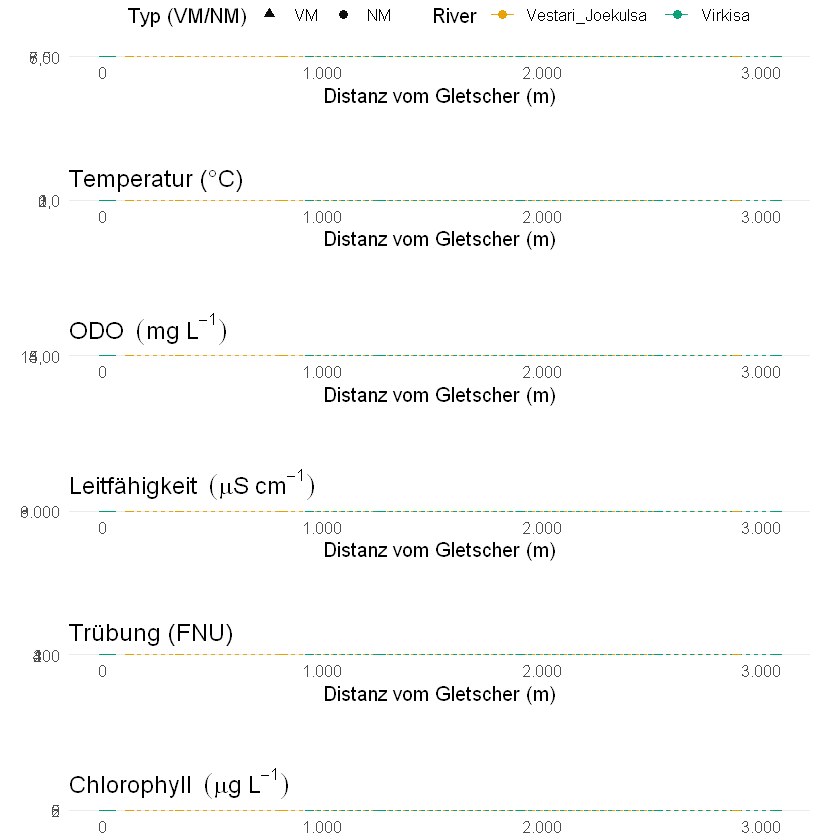

In [1]:
# ---- Setup ----
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2)
  library(scales); library(patchwork)
})

# Pfade
win_base <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
in_xls   <- file.path(win_base, "Sophia_Data.xls")
out_dir  <- file.path(win_base, "Vergleich_andere_Parameter")
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)
if (!file.exists(in_xls) && file.exists("/mnt/data/Sophia_Data.xls")) in_xls <- "/mnt/data/Sophia_Data.xls"

# ---- Daten laden ----
dat <- read_excel(in_xls)
names(dat) <- gsub("\\s+", "_", names(dat))

river_col <- "river_name"
dist_col  <- "distance_from_glacier"

params <- c("pH","Temp_C","ODO_mgperL","Cond_uSpercm","Turbidity_FNU","Chlorophyll_ugperL")
params <- params[params %in% names(dat)]
stopifnot(length(params) > 0)

# VM/NM identifizieren
vmnm_col <- NULL
for (cn in names(dat)) {
  vals <- unique(toupper(as.character(dat[[cn]])))
  if (any(vals %in% c("VM","NM"))) { vmnm_col <- cn; break }
}
stopifnot(!is.null(vmnm_col))

# optionale Gruppen-Spalte (für Virkisá Group 1)
group_candidates <- c("group_nr","Group","group","grp")
group_col <- group_candidates[group_candidates %in% names(dat)][1]

# Numerik (Komma→Punkt)
to_num <- function(x) suppressWarnings(as.numeric(gsub(",", ".", as.character(x))))
dat <- dat %>%
  mutate(Distance_m = to_num(.data[[dist_col]])) %>%
  mutate(across(all_of(params), to_num))

# Filter: ≤ 3100 m & Virkisá nur Group 1 (falls vorhanden)
df <- dat %>%
  mutate(River = as.character(.data[[river_col]]),
         VMNM  = toupper(as.character(.data[[vmnm_col]]))) %>%
  filter(!is.na(Distance_m), Distance_m <= 3100)

if (!is.na(group_col) && !is.null(group_col)) {
  df <- df %>%
    mutate(.grp = suppressWarnings(as.numeric(.data[[group_col]]))) %>%
    filter(River != "Virkisa" | .grp == 1)
}

# Long
df_long <- df %>%
  select(River, Distance_m, VMNM, all_of(params)) %>%
  pivot_longer(cols = all_of(params), names_to = "Parameter", values_to = "Value") %>%
  mutate(
    River = factor(River, levels = c("Vestari_Joekulsa","Virkisa")),
    VMNM  = factor(VMNM, levels = c("VM","NM"))
  )

# Labels
param_titles <- c(
  pH = "pH (–)",
  Temp_C = "Temperatur (°C)",
  ODO_mgperL = expression(ODO~~(mg~L^{-1})),
  Cond_uSpercm = expression(Leitfähigkeit~~(mu*S~cm^{-1})),
  Turbidity_FNU = "Trübung (FNU)",
  Chlorophyll_ugperL = expression(Chlorophyll~~(mu*g~L^{-1}))
)

# ======= HIER Farben ändern =======
col_vestari <- "#E69F00"   # z.B. "#D55E00"
col_virkisa <- "#009E73"   # z.B. "#0072B2"
cols <- c("Vestari_Joekulsa" = col_vestari,
          "Virkisa"          = col_virkisa)
# ==================================
shps <- c("VM" = 17, "NM" = 16)  # ▲ / ●

# -------- Helfer: dynamische Limits & Label-Genauigkeit --------
n_breaks <- 5           # <- Anzahl Tick-Intervalle (weniger = mehr Platz zwischen Ticks)
pad_frac <- 0.10        # <- Puffer um min/max
panel_limits_and_labels <- function(y, param, n_breaks = 5, pad_frac = 0.08) {
  r <- range(y, na.rm = TRUE)
  if (!all(is.finite(r))) r <- c(0, 1)
  if (diff(r) == 0) r <- r + c(-0.5, 0.5)
  pad <- pad_frac * diff(r)
  lower <- r[1] - pad
  upper <- r[2] + pad
  step_est <- (upper - lower) / n_breaks
  accuracy <- if (param %in% c("pH","ODO_mgperL")) 0.01 else if (step_est >= 1) 1 else if (step_est >= 0.5) 0.1 else if (step_est >= 0.2) 0.05 else 0.01
  list(
    limits = c(lower, upper),
    breaks = breaks_extended(n_breaks),
    labels = label_number(accuracy = accuracy, decimal.mark = ",", big.mark = ".")
  )
}

# ---- Hilfsfunktion: Segmente für gestrichelte Linien bauen,
# ---- aber den Abschnitt zwischen S2 und S3 bei Virkisá entfernen
build_segments <- function(d_param) {
  d_param %>%
    arrange(River, VMNM, Distance_m) %>%
    group_by(River, VMNM) %>%
    mutate(idx = row_number()) %>%
    transmute(
      River, VMNM,
      x = Distance_m, y = Value,
      xend = lead(Distance_m), yend = lead(Value),
      left_idx = idx
    ) %>%
    filter(!is.na(xend), !is.na(yend)) %>%
    # Drop nur für Virkisá: Segment 2 -> 3 unterdrücken
    filter(!(River == "Virkisa" & left_idx == 2)) %>%
    ungroup()
}

# Panel-Builder (mit gefilterten Segmenten)
make_panel <- function(param) {
  d <- dplyr::filter(df_long, Parameter == param)
  cfg <- panel_limits_and_labels(d$Value, param = param, n_breaks = n_breaks, pad_frac = pad_frac)
  seg <- build_segments(d)

  ggplot(d, aes(x = Distance_m, y = Value, colour = River, shape = VMNM)) +
    # gestrichelte Verläufe: alle Segmentpaare außer (S2->S3) bei Virkisá
    geom_segment(data = seg, inherit.aes = FALSE,
                 aes(x = x, xend = xend, y = y, yend = yend, colour = River),
                 linetype = "dashed", linewidth = 0.5, alpha = 0.7) +
    # durchgezogene Verbindung VM <-> NM pro Standort (gleiche Distanz)
    geom_line(aes(group = interaction(River, Distance_m)),
              linetype = "solid", linewidth = 0.35, alpha = 0.85, na.rm = TRUE) +
    geom_point(size = 2.2, alpha = 0.95) +
    scale_colour_manual(values = cols, name = "River", drop = FALSE) +
    scale_shape_manual(values = shps,  name = "Typ (VM/NM)", drop = FALSE) +
    scale_x_continuous("Distanz vom Gletscher (m)",
      breaks = breaks_extended(5),
      labels = label_number(accuracy = 1, decimal.mark = ",", big.mark = ".")
    ) +
    scale_y_continuous(
      name   = NULL,
      limits = cfg$limits,
      breaks = cfg$breaks,
      labels = cfg$labels,
      expand = expansion(mult = c(0, 0))
    ) +
    labs(title = param_titles[[param]]) +
    theme_minimal(base_size = 12) +
    theme(
      legend.position   = "none",
      plot.title        = element_text(face = "plain"),
      panel.grid.minor  = element_blank(),
      plot.margin       = margin(12, 12, 26, 6)
    )
}

plist <- lapply(params, make_panel)

# Stacken + gemeinsame Legende
full_plot <- wrap_plots(plist, ncol = 1) + plot_layout(guides = "collect") &
  theme(
    legend.position = "top",
    legend.title    = element_text(face = "plain"),
    legend.text     = element_text(face = "plain")
  )

print(full_plot)

# ---- Export: Textbreite + Höhe pro Panel ----
a4_text_width_cm <- 16
panel_height_cm  <- 7
extra_cm         <- 2.0
a4_height_cm     <- panel_height_cm * length(params) + extra_cm

png_file <- file.path(out_dir, "Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite_LuekeSee.png")
pdf_file <- file.path(out_dir, "Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_Verbindungen_A4Textbreite_LuekeSee.pdf")
ggsave(png_file, plot = full_plot, width = a4_text_width_cm, height = a4_height_cm, units = "cm", dpi = 300)
ggsave(pdf_file, plot = full_plot, width = a4_text_width_cm, height = a4_height_cm, units = "cm")
message("Gespeichert:\n", png_file, "\n", pdf_file)


# mit site numbern  

ERROR: Error in grDevices::pdf(file = filename, ..., version = version): kann Datei 'C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Vergleich_andere_Parameter/Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_EinLabel_oben.pdf' nicht öffnen


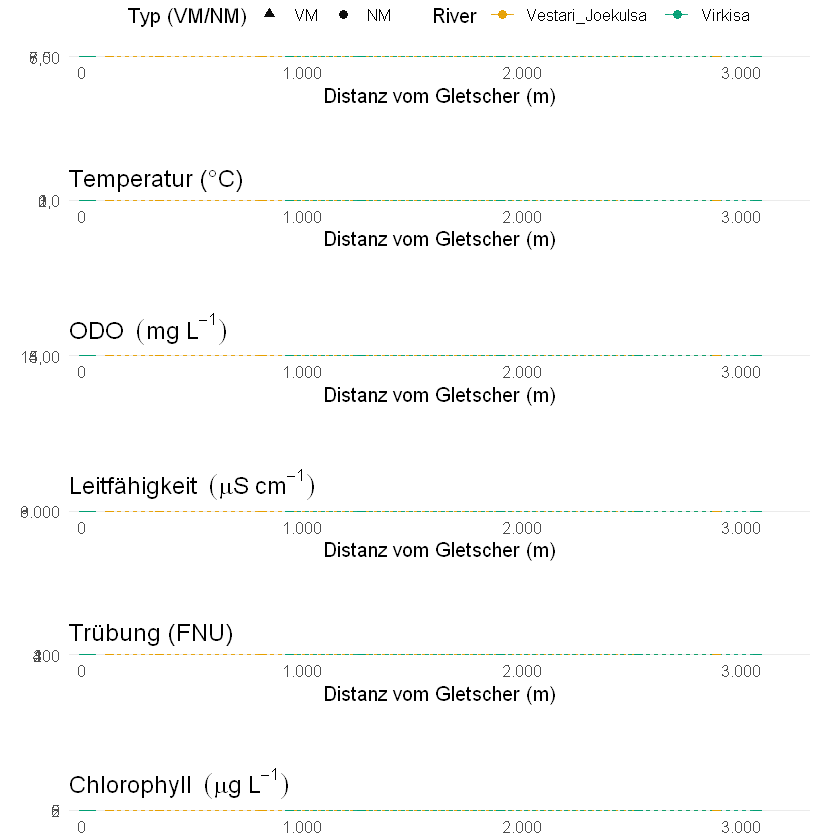

In [14]:
# ---- Setup ----
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2)
  library(scales); library(patchwork)
})

# Pfade
win_base <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
in_xls   <- file.path(win_base, "Sophia_Data.xls")
out_dir  <- file.path(win_base, "Vergleich_andere_Parameter")
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)
if (!file.exists(in_xls) && file.exists("/mnt/data/Sophia_Data.xls")) in_xls <- "/mnt/data/Sophia_Data.xls"

# ---- Daten laden ----
dat <- read_excel(in_xls)
names(dat) <- gsub("\\s+", "_", names(dat))

river_col <- "river_name"
dist_col  <- "distance_from_glacier"

params <- c("pH","Temp_C","ODO_mgperL","Cond_uSpercm","Turbidity_FNU","Chlorophyll_ugperL")
params <- params[params %in% names(dat)]
stopifnot(length(params) > 0)

# VM/NM identifizieren
vmnm_col <- NULL
for (cn in names(dat)) {
  vals <- unique(toupper(as.character(dat[[cn]])))
  if (any(vals %in% c("VM","NM"))) { vmnm_col <- cn; break }
}
stopifnot(!is.null(vmnm_col))

# optionale Gruppen-Spalte (für Virkisá Group 1)
group_candidates <- c("group_nr","Group","group","grp")
group_col <- group_candidates[group_candidates %in% names(dat)][1]

# Numerik (Komma→Punkt)
to_num <- function(x) suppressWarnings(as.numeric(gsub(",", ".", as.character(x))))
dat <- dat %>%
  mutate(Distance_m = to_num(.data[[dist_col]])) %>%
  mutate(across(all_of(params), to_num))

# Filter: ≤ 3100 m & Virkisá nur Group 1 (falls vorhanden)
df <- dat %>%
  mutate(River = as.character(.data[[river_col]]),
         VMNM  = toupper(as.character(.data[[vmnm_col]]))) %>%
  filter(!is.na(Distance_m), Distance_m <= 3100)

if (!is.na(group_col) && !is.null(group_col)) {
  df <- df %>%
    mutate(.grp = suppressWarnings(as.numeric(.data[[group_col]]))) %>%
    filter(River != "Virkisa" | .grp == 1)
}

# mögliche Standort-Spalten
site_candidates <- c("site","Site","site_no","site_nr","station","Station",
                     "Label","label","ID","id","site_id","sample_id",
                     "Standort","standort","Standort_Nr","standort_nr",
                     "Station_ID","site_code","SiteLabel")
site_col <- site_candidates[site_candidates %in% names(df)][1]
if (length(site_col) == 0) site_col <- NA_character_

# Long
keep_cols <- unique(c("River","Distance_m","VMNM", params, site_col))
df_long <- df %>%
  select(all_of(keep_cols)) %>%
  pivot_longer(cols = all_of(params), names_to = "Parameter", values_to = "Value") %>%
  mutate(
    River     = factor(River, levels = c("Vestari_Joekulsa","Virkisa")),
    VMNM      = factor(VMNM, levels = c("VM","NM")),
    SiteLabel = if (!is.na(site_col)) as.character(.data[[site_col]]) else NA_character_
  )

# Labels
param_titles <- c(
  pH = "pH (–)",
  Temp_C = "Temperatur (°C)",
  ODO_mgperL = expression(ODO~~(mg~L^{-1})),
  Cond_uSpercm = expression(Leitfähigkeit~~(mu*S~cm^{-1})),
  Turbidity_FNU = "Trübung (FNU)",
  Chlorophyll_ugperL = expression(Chlorophyll~~(mu*g~L^{-1}))
)

# ======= HIER Farben ändern =======
col_vestari <- "#E69F00"   # z.B. "#D55E00"
col_virkisa <- "#009E73"   # z.B. "#0072B2"
cols <- c("Vestari_Joekulsa" = col_vestari,
          "Virkisa"          = col_virkisa)
# ==================================
shps <- c("VM" = 17, "NM" = 16)  # ▲ / ●

# -------- Helfer: dynamische Limits & Label-Genauigkeit --------
n_breaks <- 5
pad_frac <- 0.10
label_nudge_frac <- 0.04  # vertikaler Abstand über dem höchsten Punkt (Anteil der y-Spanne)

panel_limits_and_labels <- function(y, param, n_breaks = 5, pad_frac = 0.08) {
  r <- range(y, na.rm = TRUE)
  if (!all(is.finite(r))) r <- c(0, 1)
  if (diff(r) == 0) r <- r + c(-0.5, 0.5)
  pad <- pad_frac * diff(r)
  lower <- r[1] - pad
  upper <- r[2] + pad
  step_est <- (upper - lower) / n_breaks
  accuracy <- if (param %in% c("pH","ODO_mgperL")) 0.01 else if (step_est >= 1) 1 else if (step_est >= 0.5) 0.1 else if (step_est >= 0.2) 0.05 else 0.01
  list(
    limits = c(lower, upper),
    breaks = breaks_extended(n_breaks),
    labels = label_number(accuracy = accuracy, decimal.mark = ",", big.mark = ".")
  )
}

# ---- Segmente für gestrichelte Linien (S2->S3 bei Virkisá entfernen) ----
build_segments <- function(d_param) {
  d_param %>%
    arrange(River, VMNM, Distance_m) %>%
    group_by(River, VMNM) %>%
    mutate(idx = row_number()) %>%
    transmute(
      River, VMNM,
      x = Distance_m, y = Value,
      xend = lead(Distance_m), yend = lead(Value),
      left_idx = idx
    ) %>%
    filter(!is.na(xend), !is.na(yend)) %>%
    filter(!(River == "Virkisa" & left_idx == 2)) %>% # S2->S3 unterdrücken
    ungroup()
}

# ---- Panel-Builder (ein Label pro Standort: über dem höchsten Punkt) ----
make_panel <- function(param) {
  d <- dplyr::filter(df_long, Parameter == param)

  # Limits/Formatter erst aus Daten schätzen
  cfg <- panel_limits_and_labels(d$Value, param = param, n_breaks = n_breaks, pad_frac = pad_frac)
  seg <- build_segments(d)

  # Fallback-SiteLabel, falls keine Spalte vorhanden
  site_map <- d %>%
    distinct(River, Distance_m, SiteLabel) %>%
    group_by(River) %>%
    arrange(Distance_m, .by_group = TRUE) %>%
    mutate(SiteLabel = ifelse(is.na(SiteLabel) | SiteLabel == "",
                              as.character(row_number()), SiteLabel)) %>%
    ungroup()

  # Label-Position: oberhalb des max(Wert) pro Standort
  y_span <- diff(range(d$Value, na.rm = TRUE))
  if (!is.finite(y_span) || y_span == 0) y_span <- 1
  y_bump <- label_nudge_frac * y_span

  labs_df <- d %>%
    group_by(River, Distance_m) %>%
    summarise(y_top = max(Value, na.rm = TRUE), .groups = "drop") %>%
    left_join(site_map, by = c("River","Distance_m")) %>%
    mutate(x_lab = Distance_m, y_lab = y_top + y_bump)

  # Sicherstellen, dass Labels nicht abgeschnitten werden -> obere Grenze ggf. erhöhen
  y_upper_needed <- suppressWarnings(max(labs_df$y_lab, na.rm = TRUE))
  if (!is.finite(y_upper_needed)) y_upper_needed <- cfg$limits[2]
  y_upper <- max(cfg$limits[2], y_upper_needed)
  y_limits <- c(cfg$limits[1], y_upper)

  ggplot(d, aes(x = Distance_m, y = Value, colour = River, shape = VMNM)) +
    # gestrichelte Verläufe (ohne S2->S3 bei Virkisá)
    geom_segment(data = seg, inherit.aes = FALSE,
                 aes(x = x, xend = xend, y = y, yend = yend, colour = River),
                 linetype = "dashed", linewidth = 0.5, alpha = 0.7) +
    # durchgezogene Verbindung VM <-> NM pro Standort
    geom_line(aes(group = interaction(River, Distance_m)),
              linetype = "solid", linewidth = 0.35, alpha = 0.85, na.rm = TRUE) +
    # Punkte
    geom_point(size = 2.2, alpha = 0.95) +
    # EIN Label pro Standort: über dem höchsten Punkt, zentriert
    geom_text(data = labs_df, inherit.aes = FALSE,
              aes(x = x_lab, y = y_lab, label = SiteLabel, colour = River),
              vjust = 0, hjust = 0.5, size = 2.8, show.legend = FALSE) +
    scale_colour_manual(values = cols, name = "River", drop = FALSE) +
    scale_shape_manual(values = shps,  name = "Typ (VM/NM)", drop = FALSE) +
    scale_x_continuous("Distanz vom Gletscher (m)",
      breaks = breaks_extended(5),
      labels = label_number(accuracy = 1, decimal.mark = ",", big.mark = "."),
      expand = expansion(mult = c(0.02, 0.08))  # rechts etwas Rand
    ) +
    scale_y_continuous(
      name   = NULL,
      limits = y_limits,
      breaks = cfg$breaks,
      labels = cfg$labels,
      expand = expansion(mult = c(0, 0))
    ) +
    labs(title = param_titles[[param]]) +
    theme_minimal(base_size = 12) +
    theme(
      legend.position   = "none",
      plot.title        = element_text(face = "plain"),
      panel.grid.minor  = element_blank(),
      plot.margin       = margin(12, 12, 26, 6)
    )
}

plist <- lapply(params, make_panel)

# Stacken + gemeinsame Legende
full_plot <- wrap_plots(plist, ncol = 1) + plot_layout(guides = "collect") &
  theme(
    legend.position = "top",
    legend.title    = element_text(face = "plain"),
    legend.text     = element_text(face = "plain")
  )

print(full_plot)

# ---- Export: Textbreite + Höhe pro Panel ----
a4_text_width_cm <- 16
panel_height_cm  <- 7
extra_cm         <- 2.0
a4_height_cm     <- panel_height_cm * length(params) + extra_cm

png_file <- file.path(out_dir, "Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_EinLabel_oben.png")
pdf_file <- file.path(out_dir, "Vergleich_andere_Parameter_bis3100m_panels-vert_VM-NM_EinLabel_oben.pdf")
ggsave(png_file, plot = full_plot, width = a4_text_width_cm, height = a4_height_cm, units = "cm", dpi = 300)
ggsave(pdf_file, plot = full_plot, width = a4_text_width_cm, height = a4_height_cm, units = "cm")
message("Gespeichert:\n", png_file, "\n", pdf_file)
